The question asks for given price and house size, recommend the top3 zip code for the customer. 
Certainly it would be more precise if more information is given such as customer preference(they want a bargaining price in rich area? or how many beds and baths are prefered?)or external data such as safety or transportation requirements but we can start simple. For now, my objective is to find in which zipcode the realtor can bring their customer to that give than the maximum options fullfill their requirements. 

In [1]:
import pandas as pd
data = pd.read_csv('Sacramentorealestatetransactions.csv')

In [2]:
data.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [3]:
data.describe()

,zip,beds,baths,sq__ft,price,latitude,longitude
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,95750.697462,2.911675,1.776650,1314.916751,234144.263959,38.607732,-121.355982
std,85.176072,1.307932,0.895371,853.048243,138365.839085,0.145433,0.138278
min,95603.000000,0.000000,0.000000,0.000000,1551.000000,38.241514,-121.551704
25%,95660.000000,2.000000,1.000000,952.000000,145000.000000,38.482717,-121.446127
50%,95762.000000,3.000000,2.000000,1304.000000,213750.000000,38.626582,-121.376220
75%,95828.000000,4.000000,2.000000,1718.000000,300000.000000,38.695589,-121.295778
max,95864.000000,8.000000,5.000000,5822.000000,884790.000000,39.020808,-120.597599


Quick data look-up. beds, baths, sq_ft have missing value. Also, price under 10000 seems inrealistic. I would first clean that up.

In [4]:
print (len(data[data['price']<10000]))

51


In [5]:
print (len(data[data['sq__ft']==0]))
print (len(data[(data['sq__ft']==0)&(data['beds']==0)&(data['baths']==0)]))

171
108


So 171 out of 985 data with missing information of house size, and 108 out of 171 with beth and bath room information. I am going to remove those data first. We can coming back later see if we need to build a simple model like regression or tree to fill up missing house size.

In [6]:
cols = ['zip','sq__ft','price']
data_cleaned = data.loc[(data['sq__ft']>0)&(data['price']>10000),cols]
print (len(data_cleaned))

813


Some statistics

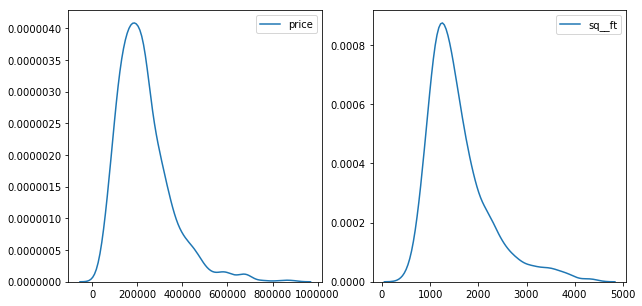

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (10,5))
sns.kdeplot(data_cleaned['price'],ax=ax1)
sns.kdeplot(data_cleaned['sq__ft'],ax=ax2)

          sq__ft     price
sq__ft  1.000000  0.728642
price   0.728642  1.000000


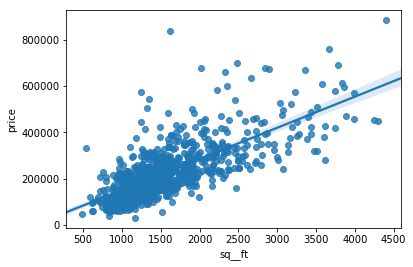

In [8]:
print (data_cleaned[['sq__ft','price']].corr())
sns.regplot(x='sq__ft',y='price',data=data_cleaned)

As we seen, distribution of house size and price are close to normal with a long tail. And they are highly correlated with coefficient ~ 0.73. It could cause the problem of multilinearity if we use this two features to build model in the future. Instead, price per sq_ft could be a better option.

In [9]:
# add price_per_size column
data_cleaned['price_per_size'] = data_cleaned.price/data_cleaned.sq__ft

In [10]:
# cut the size and price to reasonable range catagory
price_range = int(1e5) #USD
size_range = 1000 #sq_ft

price_bins = [int(x) for x in range(0,int(1e6),price_range)]
price_labels = [int(x//price_range) for x in price_bins[1:]]
data_cleaned['price_range'] = pd.cut(data_cleaned.price,price_bins,labels=price_labels)

size_bins = [int(x) for x in range(0,6000,size_range)]
size_labels = [int(x//size_range) for x in size_bins[1:]]
data_cleaned['size_range'] = pd.cut(data_cleaned.sq__ft,size_bins,labels=size_labels)

/Users/yhhsu/Anaconda/anaconda/envs/ph2t/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


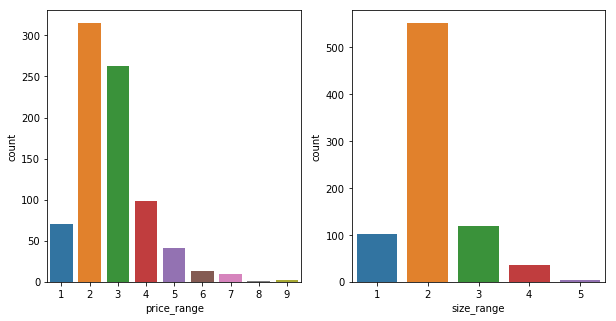

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (10,5))
sns.countplot(x = 'price_range', data=data_cleaned,ax=ax1)
sns.countplot(x = 'size_range', data=data_cleaned,ax=ax2)

In [12]:
def top3_zip(df,price, size):
    """
    return the top3 zip code based on price range and size range, sorted by average price per size in that zipcode
    """
    price_target = int(price//price_range)
    size_target = int(size//size_range)
    #print (price_target,size_target)
    filter1 = (data_cleaned.price_range==price_target)
    filter2 = (data_cleaned.size_range==size_target)
    result =  pd.DataFrame(df[filter1&filter2].groupby('zip')
                           .agg({'price_per_size':['count','mean']})).reset_index()
    result.columns = ['zip','number_of_sales','avg_price_per_size']
    result = result.sort_values(by=['number_of_sales','avg_price_per_size'], ascending=[False, True])
    return result

In [13]:
# Test Data
price = 200000
size = 1000
df = top3_zip(data_cleaned,price,size)

In [14]:
df.head()

,zip,number_of_sales,avg_price_per_size
21,95842,4,154.387317
14,95825,4,169.107468
20,95838,3,123.039887
3,95660,3,138.098914
13,95823,3,157.862677


In [15]:
df['zip'][:3]

21    95842
14    95825
20    95838
Name: zip, dtype: int64

Discussion

At the first approach to the problem, I did not apply any statistical model, just simply data wrangling and filter.
Now we can further refine our problem and make several different approaches.
- Is there other client information we can gather? their desire number of bed, bath, transportation, school, weather?
- Is there other external data we can extract the information to fulfill our objective?
